In [73]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import math
from sklearn.datasets import load_linnerud
from sklearn import linear_model
import copy

warnings.simplefilter('ignore')

In [74]:
np.random.seed(42)
EPSILON = 1e-10
TRAINING_PERCENT = 0.8
NO_OF_POINTS = 1000
DIAG_ADDITION = 3e-3 

In [75]:
linnerud = load_linnerud()
inputs = linnerud.data
outputs = linnerud.target

In [76]:
class RegressionMetrics:

    """
    Metoda care calculeaza eroarea de regresie single-output pe baza unei functii
    @params: predicted - the values computed by the model
             target - the actual values
             function - the function to be applied to the difference between the values
    @return: float
    """
    @classmethod
    def __SingleError(cls, predicted, target, function = lambda x : x):
        return (1 / len(predicted)) * sum([function(p - t) for p, t in zip(predicted, target)])

    """
    Metoda care calculeaza Mean Absolute Error pentru regresie single-output 
    @params: predicted - the values computed by the model
             target - the actual values
    @return: float
    """
    @classmethod
    def SingleMAE(cls, predicted, target):
        return RegressionMetrics.__SingleError(predicted, target, lambda x : abs(x))

    """
    Metoda care calculeaza Mean Square Error pentru regresie single-output
    @params: predicted - the values computed by the model
             target - the actual values
    @return: float
    """
    @classmethod
    def SingleMSE(cls, predicted, target):
        return RegressionMetrics.__SingleError(predicted, target, lambda x : x ** 2)

    """
    Metoda care calculeaza Root Mean Square Error pentru regresie single-output 
    @params: predicted - the values computed by the model
             target - the actual values
    @return: float
    """
    @classmethod
    def SingleRMSE(cls, predicted, target):
        return math.sqrt(RegressionMetrics.SingleMSE(predicted, target))
    
    """
    Metoda care calculeaza eroarea de regresie multi-output pe baza unei functii
    @params: predicted - the values computed by the model
             target - the actual values
             function - the function to be applied to the difference between the values
    @return: float
    """
    @classmethod
    def __MultiError(cls, predicted, target, errorFunction):
        return sum([errorFunction(pre, tar) for pre, tar in zip([[pre[i] for pre in predicted] for i in range(len(predicted[0]))], [[tar[i] for tar in target] for i in range(len(target[0]))])])

    """
    Metoda care calculeaza Mean Absolute Error pentru regresie multi-output 
    @params: predicted - the values computed by the model
             target - the actual values
    @return: float
    """
    @classmethod 
    def MultiMAE(cls, predicted, target):
        return RegressionMetrics.__MultiError(predicted, target, RegressionMetrics.SingleMAE)

    """
    Metoda care calculeaza Mean Square Error pentru regresie multi-output 
    @params: predicted - the values computed by the model
             target - the actual values
    @return: float
    """
    @classmethod 
    def MultiMSE(cls, predicted, target):
        return RegressionMetrics.__MultiError(predicted, target, RegressionMetrics.SingleMSE)

    """
    Metoda care calculeaza Root Mean Square Error pentru regresie multi-output 
    @params: predicted - the values computed by the model
             target - the actual values
    @return: float
    """
    @classmethod
    def MultiRMSE(cls, predicted, target):
        return math.sqrt(RegressionMetrics.MultiMSE(predicted, target))

In [77]:
class Utils:

    @classmethod
    def transpose(cls, matrix):
        result = []

        for j in range(len(matrix[0])):
            row = []
            for i in range(len(matrix)):
                row.append(matrix[i][j])
            result.append(row)
        
        return result

    @classmethod
    def zeroMatrix(cls, rows, columns):
        result = []
        for _ in range(rows):
            row = []
            for _ in range(columns):
                row.append(0)
            result.append(row)
        return result


    @classmethod
    def multiply(cls, mat1, mat2):
        for row in mat1:
            assert(len(row) == len(mat2))
        
        result = Utils.zeroMatrix(len(mat1), len(mat2[0]))

        for i in range(len(mat1)):
            for j in range(len(mat2[0])):
                for k in range(len(mat2)):
                    result[i][j] += mat1[i][k] * mat2[k][j]

        return result

    @classmethod
    def __cofactor(cls, mat, row, column):
        result = []
        for i in range(len(mat)):
            line = []
            if not i == row:
                for j in range(len(mat[i])):
                    if not j == column:
                        line.append(mat[i][j])
                result.append(line)
        
        return result
    
    @classmethod
    def __adjoint(cls, mat):
        adjoint = Utils.zeroMatrix(len(mat), len(mat[0]))
        for i in range(len(mat)):
            for j in range(len(mat[0])):
                cofactor = Utils.__cofactor(mat, i, j)
                sign = 1 if ((i + j) % 2 == 0) else -1
                adjoint[i][j] = sign * Utils.determinant(cofactor)

        return adjoint

    @classmethod
    def inverse(cls, mat):
        adjoint = Utils.__adjoint(mat)
        det = Utils.determinant(mat)
        
        for i in range(len(adjoint)):
            for j in range(len(adjoint[i])):
                adjoint[i][j] /= det
        
        return adjoint

    @classmethod
    def determinant(cls, mat):
        mat1 = [row[:] for row in mat]
        n = len(mat)
        result = total = 1
        temp = [0] * (len(mat) + 1)

        for i in range(n):
            index = i

            while index < n and mat1[index][i] == 0:
                index += 1
            
            if index == n:
                continue
                
            if index != i:
                for j in range(n):
                    mat1[index][j], mat1[i][j] = mat1[i][j], mat1[index][j]

                result *= (-1) ** (index - i)
            
            for j in range(n):
                temp[j] = mat1[i][j]
            
            for j in range(i + 1, n):
                num1 = temp[i]
                num2 = mat1[j][i]

                for k in range(n):
                    mat1[j][k] = (num1 * mat1[j][k]) - (num2 * temp[k])
                total = total * num1 

        for i in range(n):
            result *= mat1[i][i] 
        
        return result / total 
    
    @classmethod
    def fillNone(cls, mat):
        for j in range(len(mat[0])):
            noneIndexes = []
            mean = 0
            for i in range(len(mat)):
                if math.isnan(mat[i][j]):
                    noneIndexes.append(i)
                else:
                    mean += mat[i][j]
            if len(noneIndexes):
                mean = mean / (len(mat) - len(noneIndexes))
                for index in noneIndexes:
                    mat[index][j] = mean
    
    @classmethod
    def __mean(cls, data):
        return sum(data) / len(data)
    
    @classmethod
    def __std(cls, data):
        mean = Utils.__mean(data)
        return math.sqrt(sum([(d - mean) ** 2 for d in data]) / (len(data) - 1))
    
    @classmethod
    def normalize(cls, data):
        for j in range(len(data[0])):
            column = [data[i][j] for i in range(len(data))]
            mean = Utils.__mean(column)
            std = Utils.__std(column)
            for i in range(len(data)):
                data[i][j] = (data[i][j] - mean) / std

    @classmethod
    def transform(cls, mat):
        if Utils.determinant(mat) < EPSILON:
            for i in range(len(mat)):
                mat[i][i] = mat[i][i] + DIAG_ADDITION

In [78]:
Utils.fillNone(inputs)
Utils.normalize(inputs)

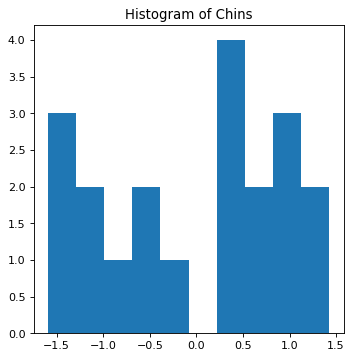

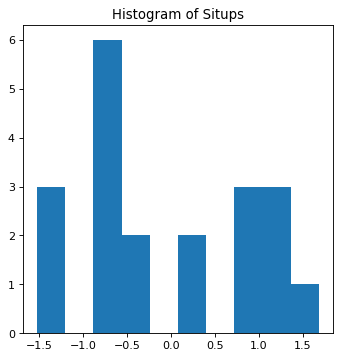

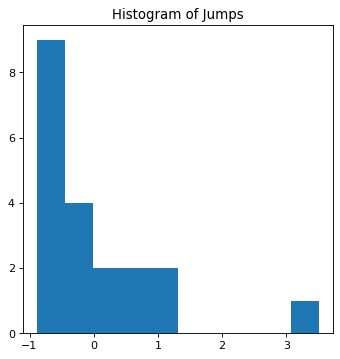

In [79]:
def plotHistogram(x, variableName):
    plt.figure(figsize = (5, 5), dpi = 80)
    n, bins, patches = plt.hist(x, 10)
    plt.title('Histogram of ' + variableName)
    plt.show()

plotHistogram([inp[0] for inp in inputs], linnerud.feature_names[0])
plotHistogram([inp[1] for inp in inputs], linnerud.feature_names[1])
plotHistogram([inp[2] for inp in inputs], linnerud.feature_names[2])

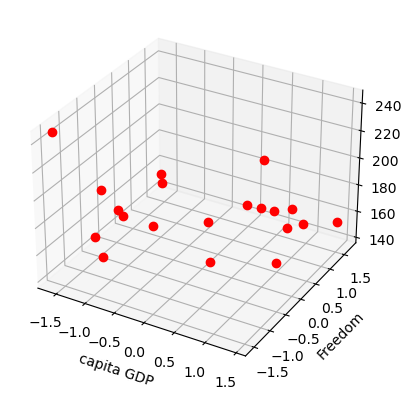

In [80]:
def plotData(inputs, outputs):
    ax = plt.axes(projection = '3d')
    ax.plot3D([inp[0] for inp in inputs], [inp[1] for inp in inputs], [out[0] for out in outputs], 'ro')
    ax.set_xlabel('capita GDP')
    ax.set_ylabel('Freedom')
    plt.show()
plotData(inputs, outputs)

In [81]:
def splitData(inputs, outputs):
    indexes = [i for i in range(len(inputs))]
    trainIndexes = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    validationIndexes = [i for i in indexes if i not in trainIndexes] 

    trainInputs = [inputs[i] for i in trainIndexes]
    trainOuputs = [outputs[i] for i in trainIndexes]

    validationInputs = [inputs[i] for i in validationIndexes]
    validationOuputs = [outputs[i] for i in validationIndexes]

    return [[trainInputs, trainOuputs], [validationInputs, validationOuputs]]

[train, validation] = splitData(inputs, outputs)
trainInputs = train[0]
trainOutputs = train[1]
validationInputs = validation[0]
validationOutputs = validation[1]

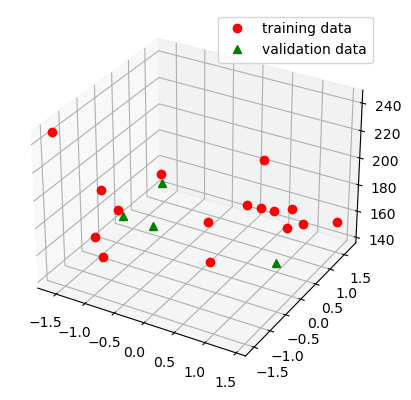

In [82]:
def plotSplitData(train, validation):
    ax = plt.axes(projection = '3d')
    ax.plot3D([tr[0] for tr in train[0]], [tr[1] for tr in train[0]], [tr[0] for tr in train[1]], 'ro', label = 'training data')
    ax.plot3D([val[0] for val in validation[0]], [val[1] for val in validation[0]], [val[0] for val in validation[1]], 'g^', label = 'validation data')
    plt.legend()
    plt.show()

plotSplitData(train, validation)

In [83]:
params = {'lr': 0.001, 'epochs': 100, 'errorFunction': RegressionMetrics.SingleMAE, 'batch_size': 16}

In [84]:
class RegressorGD:
    
    def __init__(self, params):
        self.__params = params

    @property
    def weights(self):
        return self.__weights
        #return [self.__result[0][1], self.__result[0][1]] 

    def __initWeights(self, input_size, output_size):
        self.__weights = [] 
        for _ in range(output_size):
            self.__weights.append(list(np.random.random(size = input_size + 1)))
            
    def __learnBatch(self, inputs, outputs):
        errors = [0 for _ in range(len(outputs[0]))]
        batch_size = len(inputs)

        for input, output in zip(inputs, outputs):
            o = self.predict([input])[0]

            for j in range(len(self.__weights)):
                error = output[j] - o[j] #self.__params['errorFunction']([o[j]], [output[j]])
                for i in range(1, len(self.__weights[j])):
                    self.__weights[j][i] += (1 / batch_size) * self.__params['lr'] * error * input[i - 1]

                self.__weights[j][0] += self.__params['lr'] * error
    
    def fit(self, inputs, outputs):
        self.__initWeights(len(inputs[0]), len(outputs[0]))

        noBatches = int(len(inputs) / params['batch_size']) + (1 if (len(inputs) % params['batch_size'] > 0) else 0)

        for i in range(noBatches - 1):
            input = inputs[(i * params['batch_size']):((i + 1) * params['batch_size'])]
            output = inputs[(i * params['batch_size']):((i + 1) * params['batch_size'])]
            self.__learnBatch(input, output)
        #for _ in range(self.__params['epochs']):
        #    for input, output in zip(inputs, outputs):
        #        self.__learnBatch([input], [output])


    def predict(self, inputs):
        return [[np.dot(input, weight[1:]) + weight[0] for weight in self.__weights] for input in inputs]
    

In [85]:
regressor = RegressorGD(params = params)
regressor.fit(trainInputs, trainOutputs)

In [86]:
def learnWithTool(trainInputs, trainOutputs):
    regressor = linear_model.SGDRegressor()
    regressor.fit(trainInputs, trainOutputs)

    return regressor

#regressor = learnWithTool(trainInputs, trainOutputs)

In [87]:
def plotRegressor(regressor, inputs, outputs):
    x = np.linspace(min([inp[0] for inp in inputs]), max([inp[0] for inp in inputs]), num = NO_OF_POINTS)
    y = np.linspace(min([inp[1] for inp in inputs]), max([inp[1] for inp in inputs]), num = NO_OF_POINTS)
    z = np.array([regressor.predict([[xVal, yVal]])[0] for xVal, yVal in zip(x, y)])

    ax = plt.axes(projection = '3d')
    ax.plot_surface(x, y, z, alpha = 0.2)
    ax.plot3D([inp[0] for inp in inputs], [inp[1] for inp in inputs], [out[0] for out in outputs], 'ro', label = 'train data')
    plt.legend()
    plt.show()

#plotRegressor(regressor, trainInputs, trainOutputs)

In [88]:
def plotPredictions(regressor, inputs, outputs):
    ax = plt.axes(projection = '3d')
    x = [inp[0] for inp in inputs]
    y = [inp[1] for inp in inputs]
    outputs = [out[0] for out in outputs]

    ax.plot3D(x, y, outputs, 'ro', label = 'validation data')
    ax.plot3D(x, y, [pre[0] for pre in regressor.predict(inputs)], 'g^', label = 'predicted data')
    plt.legend()
    plt.show()

#plotPredictions(regressor, validationInputs, validationOutputs)

In [89]:
def computeError(regressor, inputs, outputs, errorFunction):
    return errorFunction(regressor.predict(inputs), outputs)

print(computeError(regressor, validationInputs, validationOutputs, RegressionMetrics.MultiRMSE))

197.62606382158197


In [90]:
#regressor = learnWithTool(trainInputs, trainOutputs)
def computeError(regressor, inputs, outputs, errorFunction):
    return errorFunction(regressor.predict(inputs), outputs)

#print(computeError(regressor, validationInputs, validationOutputs, RegressionMetrics.SingleMSE))